# Metadata

```yaml
Course:   DS 5001
Module:   04 Lab
Topic:    Predict POS with an HMM
Author:   R.C. Alvarado
Date:     5 February 2022 (revised)
```

**Purpose**: Demonstrate Hidden Markov Model applied to POS detection, including the Viterbi algorithm by hand.

# Set Up

In [1]:
data_home = '../data'
data_prefix = 'austen-melville'

In [2]:
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
SENT = OHCO[:4]

In [3]:
import pandas as pd
import numpy as np
import nltk
import re

/Users/rca2t1/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import scipy as sp

In [5]:
sp.__version__

'1.7.3'

# Get Annotated `TOKEN` Table

We use the `CORPUS` table from our previous exercise.

In [6]:
TOKEN = pd.read_csv(f"{data_home}/output/{data_prefix}-CORPUS.csv").set_index(OHCO)

In [7]:
TOKEN

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                                 
105     1       1        0        0                   ('Sir', 'NNP')  NNP   
                                  1                ('Walter', 'NNP')  NNP   
                                  2               ('Elliot,', 'NNP')  NNP   
                                  3                     ('of', 'IN')   IN   
                                  4              ('Kellynch', 'NNP')  NNP   
...                                                              ...  ...   
34970   114     24       0        6                    ('The', 'DT')   DT   
                                  7          ('Ambiguities,', 'NNP')  NNP   
                                  8                     ('by', 'IN')   IN   
                                  9                ('Herman', 'NNP')  NNP   
                                  10             ('Melville', 'NNP')  NNP   

                                                token_str     term_str  
book_id chap_id para_num sent_num token_num                             
105     1       1        0        0                   Sir          sir  
                                  1                Walter       walter  
                                  2               Elliot,       elliot  
                                  3                    of           of  
                                  4              Kellynch     kellynch  
...                                                   ...          ...  
34970   114     24       0        6                   The          the  
                                  7          Ambiguities,  ambiguities  
                                  8                    by           by  
                                  9                Herman       herman  
                                  10             Melville     melville  

[2059272 rows x 4 columns]

# Create Table of POS Tags 

We create a table rrom the Penn Treebank Project list of part-of-speech tags.

## Grab UPenn Codes

We get a text version of the UPenn Codes, or tag set, by calling `nltk.help.upenn_tagset()`. The extra information can be used later in visualizations, etc.

In [8]:
POS = pd.read_csv(f'{data_home}/misc/upenn_tagset.txt', sep='\t', names=['pos_code','def'])
POS = POS[POS.pos_code.str.match(r'^\w')].set_index('pos_code') # Keep only letter codes

In [9]:
POS

,def
pos_code,
CC,"conjunction, coordinating"
CD,"numeral, cardinal"
DT,determiner
EX,existential there
FW,foreign word
IN,"preposition or conjunction, subordinating"
JJ,"adjective or numeral, ordinal"
JJR,"adjective, comparative"
JJS,"adjective, superlative"


## Add value counts

In [10]:
POS['n'] = TOKEN.pos.value_counts().to_frame().sort_index()
POS['n'] = POS['n'].fillna(0).astype('int')

In [11]:
POS.sort_values('n', ascending=False)

,def,n
pos_code,,
NN,"noun, common, singular or mass",383976
IN,"preposition or conjunction, subordinating",264122
DT,determiner,204813
JJ,"adjective or numeral, ordinal",155155
PRP,"pronoun, personal",117186
RB,adverb,113500
VBD,"verb, past tense",104096
NNP,"noun, proper, singular",97366
VB,"verb, base form",90361


## Create `POS_GROUP` table

We want a simplified list of grammatical categories. We use the first two letters of each code name as our group.

In [12]:
# Add pos_group feature to POS and TOKEN
POS['pos_group'] = POS.apply(lambda x: x.name[:2], 1)
TOKEN['pos_group'] = TOKEN.pos.str[:2]

In [13]:
# Generate new table from it
POS_GROUP = POS.groupby('pos_group').n.sum().to_frame('n')
POS_GROUP = POS_GROUP[POS_GROUP.n > 0]
POS_GROUP['def'] = POS.groupby('pos_group').apply(lambda x: '; '.join(x['def']))
POS_GROUP['p'] = POS_GROUP.n / POS_GROUP.n.sum()
POS_GROUP['i'] = np.log2(1/POS_GROUP.p)
POS_GROUP['h'] = POS_GROUP.p * POS_GROUP.i

In [14]:
POS_GROUP.sort_values('i').style.background_gradient(cmap='YlGnBu')

,n,def,p,i,h
pos_group,,,,,
NN,540387,"noun, common, singular or mass; noun, proper, singular; noun, proper, plural; noun, common, plural",0.262457,1.929850,0.506502
VB,356879,"verb, base form; verb, past tense; verb, present participle or gerund; verb, past participle; verb, present tense, not 3rd person singular; verb, present tense, 3rd person singular",0.173330,2.528407,0.438249
IN,264122,"preposition or conjunction, subordinating",0.128279,2.962638,0.380046
DT,204813,determiner,0.099474,3.329535,0.331203
PR,176261,"pronoun, personal; pronoun, possessive",0.085607,3.546129,0.303573
JJ,165133,"adjective or numeral, ordinal; adjective, comparative; adjective, superlative",0.080202,3.640214,0.291953
RB,119059,"adverb; adverb, comparative; adverb, superlative",0.057825,4.112166,0.237785
CC,83450,"conjunction, coordinating",0.040530,4.624859,0.187446
TO,55581,"""to"" as preposition or infinitive marker",0.026995,5.211179,0.140674


# Extract Model from `TOKEN`

In [15]:
TOKEN = TOKEN.join(POS, on="pos_group", rsuffix='_y').dropna()

In [16]:
TOKEN

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                                 
105     1       1        0        0                   ('Sir', 'NNP')  NNP   
                                  1                ('Walter', 'NNP')  NNP   
                                  2               ('Elliot,', 'NNP')  NNP   
                                  3                     ('of', 'IN')   IN   
                                  4              ('Kellynch', 'NNP')  NNP   
...                                                              ...  ...   
34970   114     24       0        6                    ('The', 'DT')   DT   
                                  7          ('Ambiguities,', 'NNP')  NNP   
                                  8                     ('by', 'IN')   IN   
                                  9                ('Herman', 'NNP')  NNP   
                                  10             ('Melville', 'NNP')  NNP   

                                                token_str     term_str  \
book_id chap_id para_num sent_num token_num                              
105     1       1        0        0                   Sir          sir   
                                  1                Walter       walter   
                                  2               Elliot,       elliot   
                                  3                    of           of   
                                  4              Kellynch     kellynch   
...                                                   ...          ...   
34970   114     24       0        6                   The          the   
                                  7          Ambiguities,  ambiguities   
                                  8                    by           by   
                                  9                Herman       herman   
                                  10             Melville     melville   

                                            pos_group  \
book_id chap_id para_num sent_num token_num             
105     1       1        0        0                NN   
                                  1                NN   
                                  2                NN   
                                  3                IN   
                                  4                NN   
...                                               ...   
34970   114     24       0        6                DT   
                                  7                NN   
                                  8                IN   
                                  9                NN   
                                  10               NN   

                                                                                    def  \
book_id chap_id para_num sent_num token_num                                               
105     1       1        0        0                      noun, common, singular or mass   
                                  1                      noun, common, singular or mass   
                                  2                      noun, common, singular or mass   
                                  3           preposition or conjunction, subordinating   
                                  4                      noun, common, singular or mass   
...                                                                                 ...   
34970   114     24       0        6                                          determiner   
                                  7                      noun, common, singular or mass   
                                  8           preposition or conjunction, subordinating   
                                  9                      noun, common, singular or mass   
                                  10                     noun, common, singular or mass   

                                                    n pos_group_y  
book_id chap_id para_num sent_num token_num                        
105     1       1        0      

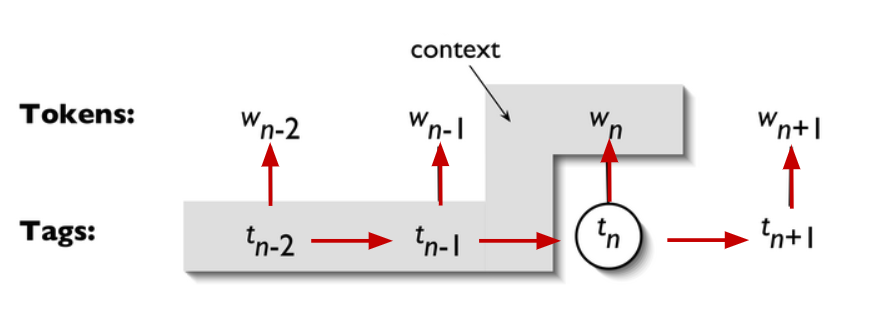
<img src="images/hmm.png" width="750">

## Create Table of $t_n \rightarrow t_{n+1}$ Transissions ($A$)

**Add sentence boundaries to sequence**

Note that we are breaking our data by adding `<s>` as a key, although 
it is not part of the UPenn tagset. We might consider creating a code 
for sentence beginnings or endings, such as the stop tag in Eistenstein 2019.

In [17]:
A = TOKEN[['pos_group']].join(TOKEN[['pos_group']].shift(-1), lsuffix='_x', rsuffix="_y")\
    .value_counts().to_frame('n').sort_index()

In [18]:
A['cp'] = A.n / A.groupby('pos_group_x').n.sum()  # P(y|x)

In [19]:
A

n        cp
pos_group_x pos_group_y                
CC          CC            117  0.001402
            CD           1162  0.013925
            DT           9585  0.114859
            EX            442  0.005297
            FW              1  0.000012
...                       ...       ...
WP          MD           1161  0.107779
            NN           1521  0.141199
            RB            525  0.048737
            TO            119  0.011047
            VB           5872  0.545117

[205 rows x 2 columns]

In [20]:
AM = A.cp.unstack(fill_value=0)

In [21]:
AM.style.background_gradient(axis=None)

pos_group_y,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,RB,RP,TO,UH,VB,WP
pos_group_x,,,,,,,,,,,,,,,,
CC,0.001402,0.013925,0.114859,0.005297,0.000012,0.105620,0.088424,0.000000,0.024841,0.248209,0.103583,0.000024,0.010030,0.000012,0.275183,0.008580
CD,0.059794,0.016098,0.009120,0.000397,0.000079,0.168438,0.098652,0.000000,0.018002,0.513561,0.017684,0.000159,0.010706,0.000000,0.078588,0.008723
DT,0.001094,0.009667,0.002046,0.000112,0.000308,0.013202,0.247465,0.000000,0.002676,0.658044,0.028870,0.000142,0.001396,0.000005,0.033426,0.001548
EX,0.002119,0.001324,0.025424,0.000000,0.000000,0.020922,0.010593,0.000000,0.092956,0.016419,0.029396,0.000000,0.001589,0.000000,0.798994,0.000265
FW,0.040816,0.018367,0.175510,0.000000,0.057143,0.022449,0.075510,0.000000,0.006122,0.430612,0.059184,0.002041,0.004082,0.000000,0.108163,0.000000
IN,0.003771,0.012369,0.361609,0.002344,0.000435,0.039046,0.095100,0.000000,0.013906,0.320852,0.024780,0.000117,0.009863,0.000000,0.109041,0.006766
JJ,0.050493,0.005232,0.024156,0.000799,0.000400,0.091696,0.070016,0.000000,0.009120,0.630673,0.021558,0.000418,0.033785,0.000073,0.060127,0.001453
LS,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000
MD,0.004674,0.000784,0.011796,0.000063,0.000000,0.013333,0.001286,0.000000,0.000345,0.008094,0.256431,0.000094,0.011890,0.000000,0.691021,0.000188


## Pause to explore

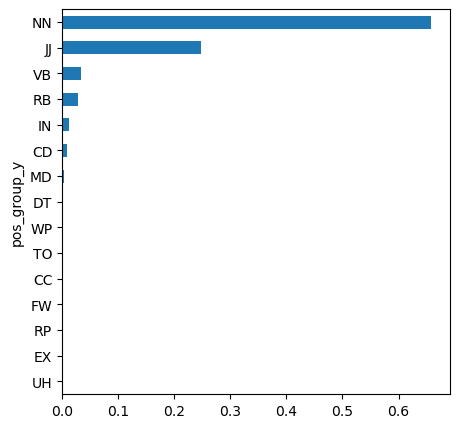

In [ ]:
A.loc['DT'].cp.sort_values().plot.barh(figsize=(5,5)); # P(Ty|Tx)

In [ ]:
import sys
sys.path.append('../lib')
from hac import HAC

<Figure size 640x480 with 0 Axes>

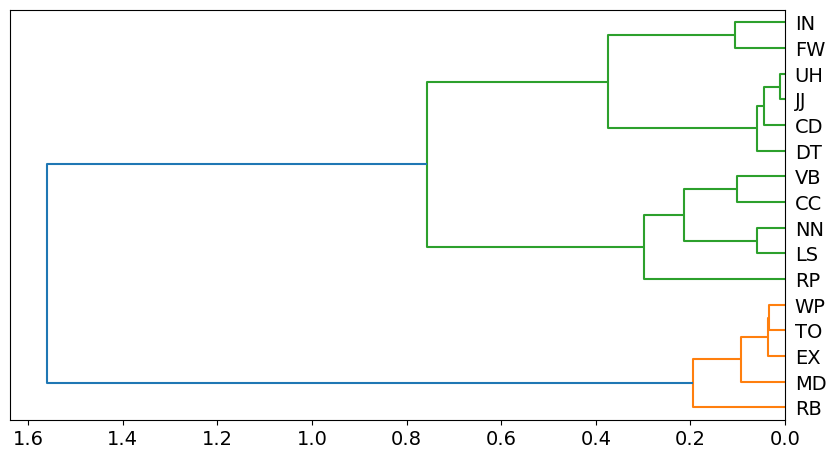

In [ ]:
HAC(AM).plot();

In [ ]:
POS_GROUP.loc["RP IN VB CC NN LS".split()]

,n,def,p,i,h
pos_group,,,,,
RP,7897,particle,0.003835,8.026394,0.030785
IN,264122,"preposition or conjunction, subordinating",0.128279,2.962638,0.380046
VB,356879,"verb, base form; verb, past tense; verb, pr...",0.173330,2.528407,0.438249
CC,83450,"conjunction, coordinating",0.040530,4.624859,0.187446
NN,540387,"noun, common, singular or mass; noun, proper...",0.262457,1.929850,0.506502
LS,3,list item marker,0.000001,19.388520,0.000028


In [ ]:
POS_GROUP.loc[['FW','DT','CD','JJ','UH']]

,n,def,p,i,h
pos_group,,,,,
FW,490,foreign word,0.000238,12.036845,0.002865
DT,204813,determiner,0.099474,3.329535,0.331203
CD,12610,"numeral, cardinal",0.006124,7.351202,0.045022
JJ,165133,"adjective or numeral, ordinal; adjective, co...",0.080202,3.640214,0.291953
UH,74,interjection,0.000036,14.764030,0.000531


In [ ]:
POS_GROUP.loc[['RB','MD','TO','EX','WP']]

,n,def,p,i,h
pos_group,,,,,
RB,119059,"adverb; adverb, comparative; adverb, superl...",0.057825,4.112166,0.237785
MD,31876,modal auxiliary,0.015482,6.013300,0.093096
TO,55581,"""to"" as preposition or infinitive marker",0.026995,5.211179,0.140674
EX,3776,existential there,0.001834,9.090840,0.016672
WP,10772,"WH-pronoun; WH-pronoun, possessive",0.005232,7.578484,0.039649


## Create Table of Initial State Probabilities $\Pi$

We get counts of pos tags that appear at the beginnings of sentences. 

Note: since
we took the trouble to create an OHCO index, we don't need to add `<s>` markers
to find out these frequencies.

In [ ]:
PI = TOKEN.query("token_num == 0").pos_group.value_counts().to_frame('n').sort_index()
PI.index.name = 'pos_group'
PI['cp'] = PI.n / PI.n.sum()

## Make sure $\Pi$ shares sample space with $A$ and $B$

Find out what is missing from PI.\
This will be important below.

In [ ]:
for tag in (set(AM.index) - set(PI.index)):
    PI.loc[tag, ['n', 'cp']] = (0, 0)

In [ ]:
PI

,n,cp
pos_group,,
CC,7864.0,0.107065
CD,743.0,0.010116
DT,9868.0,0.134348
EX,917.0,0.012485
FW,8.0,0.000109
IN,10245.0,0.139481
JJ,4380.0,0.059632
LS,3.0,0.000041
MD,418.0,0.005691


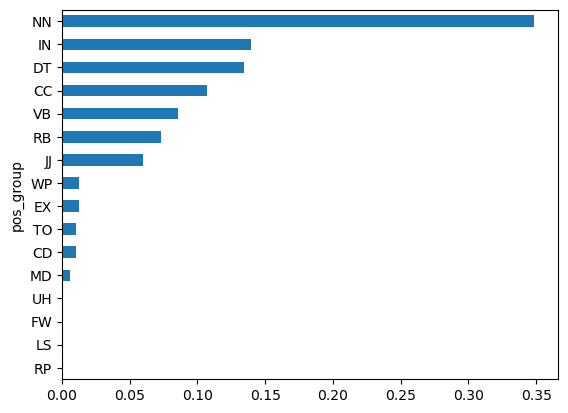

In [ ]:
PI.sort_values('cp', ascending=True).cp.plot.barh();

## Create Table of $t_n \rightarrow o_n$ Emissions ($ B $)

In [ ]:
B = TOKEN[['pos_group', 'term_str']].value_counts().to_frame('n').sort_index()
B.index.names = ['pos_group_y', 'term_str']
B['cp'] = B.n / B.groupby('pos_group_y').n.sum()

In [ ]:
B.head()

n        cp
pos_group_y term_str                   
CC          acquired        1  0.000012
            ah              1  0.000012
            all             2  0.000024
            altogether      3  0.000036
            and         60705  0.727442

In [ ]:
BM = B.cp.unstack(fill_value=0)

In [ ]:
BM

term_str,0,1,10,100,1000,10000,10000000,10440,10800,10th,...,zoroaster,zozo,zuma,zur,à,æneas,æniad,æson,æsops,ł20000
pos_group_y,,,,,,,,,,,,,,,,,,,,,
CC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CD,0.000159,0.001348,0.000476,0.000159,0.000159,0.000238,0.000079,0.000079,0.000159,0.000079,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
EX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
IN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
JJ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000006,0.000000,0.000000,0.000000,0.000000,0.000000
LS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# The Viterbi Algorithm

The Vertibi implements the optimization function:

<img src="images/formula.png" width="400">

<img src="images/viterbi.png" width="750">

# Implement Simplified Version

We implement a version that is simpler than the pseudo code but achieves the same result.

We also start with using plain old Python constructs -- lists and loops -- and later modify our code to work with Pandas and the ETA data model (F2).

In [71]:
test_sentences = [s.strip() for s in open(f"{data_home}/misc/test_sentences.txt").readlines()]

In [74]:
TEST_SENTENCES = pd.DataFrame({'sent_str':test_sentences})
TEST_SENTENCES.index.name = 'sent_id'

In [75]:
TEST_SENTENCES

,sent_str
sent_id,
0,the quick brown fox jumped over the lazy dogs
1,The event had every promise of happiness for h...
2,Mr Weston was a man of unexceptionable charact...
3,but it was a black morning's work for her
4,The want of Miss Taylor would be felt every ho...
5,She recalled her past kindness the kindness th...
6,how she had taught and how she had played with...
7,how she had devoted all her powers to attach a...
8,and how nursed her through the various illness...


In [84]:
my_test = TEST_SENTENCES.sample().sent_str.values[0]

In [88]:
my_test

'one to whom she could speak every thought as it arose'

In [89]:
R = [] # List of predicted tags
L = [] # The Lattice of Coincidence :-)
for i, w in enumerate(my_test.lower().split()):
    p1 = AM[R[i-1]] if i > 0 else PI.cp
    p2 = BM[w]
    p3 = p1 * p2
    r = p3.idxmax()    
    R.append(r)
    print(w, r, end=" ")
    L.append(p3)

X = pd.DataFrame(L, index=[f"{i}:{w}" for i, w in enumerate(my_test.split())]).T.fillna(0)

one CD to TO whom WP she NN could MD speak VB every DT thought VB as IN it NN arose VB 

In [90]:
X.style.background_gradient(cmap='YlGnBu')

,0:one,1:to,2:whom,3:she,4:could,5:speak,6:every,7:thought,8:as,9:it,10:arose
CC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,0.000000,0.000000
CD,0.004803,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000
DT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000475,0.000000,0.000000,0.000000,0.000000
EX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000006,0.000000
FW,0.000000,0.000037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000046,0.000000
IN,0.000013,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,0.006395,0.000001,0.000004
JJ,0.000030,0.000003,0.000001,0.000001,0.000015,0.000002,0.000002,0.000006,0.000008,0.000330,0.000004
LS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MD,0.000001,0.000000,0.000000,0.000000,0.001358,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NN,0.000655,0.000003,0.000003,0.000006,0.000014,0.000006,0.000008,0.000034,0.000068,0.001966,0.000004


In [91]:
X.idxmax().to_frame('tag').T

,0:one,1:to,2:whom,3:she,4:could,5:speak,6:every,7:thought,8:as,9:it,10:arose
tag,CD,TO,WP,NN,MD,VB,DT,VB,IN,NN,VB


In [ ]:
def viterbi_mod(sent_str, verbose=True):

    # Extract sentence data
    K = sent_str.lower().split()
    K = pd.Series(K).str.replace(r"[\W_]+", "", regex=True).to_list()
    N = [i for i in range(len(K))]
    T = AM.index

    # Define dataframes
    IDX = pd.MultiIndex.from_arrays([N,K], names=['order','word'])
    LATTICE = pd.DataFrame(index=IDX, columns=T).T
    LATTICE.index.name = 'pos_group'
    PREDICT = pd.DataFrame({'tag':None}, index=IDX)

    # Initialize 
    LATTICE[0] = PI.cp
    PREDICT.loc[0, 'tag'] = LATTICE[0].idxmax().values[0]
    PREDICT.loc[0, 'p'] = LATTICE[0].max().values[0]

    # Predict
    for i in range(1, len(K)):
        prev_tag = PREDICT.loc[i-1, 'tag'].values[0]
        cur_word = LATTICE[i].columns[0]
        p1 = AM[prev_tag]
        p2 = BM[cur_word]
        p3 = p1 * p2
        LATTICE[i] = p3
        PREDICT.loc[i, 'tag'] = p3.idxmax()
        PREDICT.loc[i, 'p'] = p3.max()

    PREDICT['i'] = np.log2(1/PREDICT.p)

    result = " ".join([f"{w}/{t}" for w, t in PREDICT.reset_index()[['word','tag']].values])
    pp = 2**PREDICT.i.mean()
    if verbose:
        print(result, f"(PP:{round(pp,2)})")
    
    return LATTICE, PREDICT, pp, result

## Try on one sentence

In [ ]:
S = test_sentences[5]
L1, P1, pp1, result = viterbi_mod(S)

she/NN recalled/VB her/NN past/JJ kindness/NN the/DT kindness/NN the/DT affection/NN of/IN sixteen/JJ years/FW (PP:1094.13)


In [ ]:
P1.style.background_gradient(cmap="YlGnBu")

,,tag,p,i
order,word,,,
0,she,NN,0.348722,1.519850
1,recalled,VB,0.000021,15.553028
2,her,NN,0.000743,10.395259
3,past,JJ,0.000519,10.910841
4,kindness,NN,0.000010,16.615426
5,the,DT,0.349895,1.515007
6,kindness,NN,0.000019,15.678499
7,the,DT,0.349895,1.515007
8,affection,NN,0.000026,15.241368


In [ ]:
L1.style.background_gradient(cmap='YlGnBu')

order,0,1,2,3,4,5,6,7,8,9,10,11
word,she,recalled,her,past,kindness,the,kindness,the,affection,of,sixteen,years
pos_group,,,,,,,,,,,,
CC,0.107065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003
CD,0.010116,0.000000,0.000000,0.000000,0.000000,0.000285,0.000000,0.000285,0.000000,0.000000,0.000000,0.000008
DT,0.134348,0.000000,0.000000,0.000000,0.000000,0.349895,0.000000,0.349895,0.000000,0.000000,0.000000,0.000000
EX,0.012485,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FW,0.000109,0.000000,0.000000,0.000000,0.000000,0.001758,0.000000,0.001758,0.000000,0.000000,0.000000,0.000154
IN,0.139481,0.000000,0.000000,0.000058,0.000000,0.000004,0.000000,0.000004,0.000000,0.078817,0.000000,0.000000
JJ,0.059632,0.000008,0.000045,0.000519,0.000001,0.000905,0.000000,0.000905,0.000001,0.000237,0.000017,0.000006
LS,0.000041,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Try on all sentences

First, create a dataframe out of our list of test sentences.

In [ ]:
TEST_SENTENCES = pd.DataFrame({'sent_str_raw':test_sentences})
TEST_SENTENCES.index.name = 'sent_id'

In [ ]:
TEST_SENTENCES.head()

,sent_str_raw
sent_id,
0,the quick brown fox jumped over the lazy dogs
1,The event had every promise of happiness for h...
2,Mr Weston was a man of unexceptionable charact...
3,but it was a black morning's work for her
4,The want of Miss Taylor would be felt every ho...


In [ ]:
R = []
for i, row in TEST_SENTENCES.iterrows():
    L, P, pp, r = viterbi_mod(row.sent_str_raw, verbose=False)
    TEST_SENTENCES.loc[i, 'pp'] = pp
    TEST_SENTENCES.loc[i, 'r'] = r
    R.append((L,P))

In [ ]:
TEST_SENTENCES

,sent_str_raw,pp,r
sent_id,,,
0,the quick brown fox jumped over the lazy dogs,14665.185668,the/NN quick/JJ brown/JJ fox/JJ jumped/VB over...
1,The event had every promise of happiness for h...,1123.874046,the/NN event/FW had/VB every/DT promise/VB of/...
2,Mr Weston was a man of unexceptionable charact...,2224.767772,mr/NN weston/NN was/VB a/DT man/FW of/IN unexc...
3,but it was a black morning's work for her,992.743314,but/NN it/JJ was/VB a/DT black/JJ mornings/FW ...
4,The want of Miss Taylor would be felt every ho...,1095.625944,the/NN want/VB of/IN miss/NN taylor/NN would/M...
5,She recalled her past kindness the kindness th...,1094.131535,she/NN recalled/VB her/NN past/JJ kindness/NN ...
6,how she had taught and how she had played with...,2292.588778,how/NN she/FW had/VB taught/VB and/CC how/NN s...
7,how she had devoted all her powers to attach a...,1874.438561,how/NN she/FW had/VB devoted/VB all/DT her/VB ...
8,and how nursed her through the various illness...,3476.842428,and/NN how/JJ nursed/VB her/NN through/IN the/...


In [ ]:
R[5][0].style.background_gradient(cmap="YlGnBu")

order,0,1,2,3,4,5,6,7,8,9,10,11
word,she,recalled,her,past,kindness,the,kindness,the,affection,of,sixteen,years
pos_group,,,,,,,,,,,,
CC,0.107065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003
CD,0.010116,0.000000,0.000000,0.000000,0.000000,0.000285,0.000000,0.000285,0.000000,0.000000,0.000000,0.000008
DT,0.134348,0.000000,0.000000,0.000000,0.000000,0.349895,0.000000,0.349895,0.000000,0.000000,0.000000,0.000000
EX,0.012485,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FW,0.000109,0.000000,0.000000,0.000000,0.000000,0.001758,0.000000,0.001758,0.000000,0.000000,0.000000,0.000154
IN,0.139481,0.000000,0.000000,0.000058,0.000000,0.000004,0.000000,0.000004,0.000000,0.078817,0.000000,0.000000
JJ,0.059632,0.000008,0.000045,0.000519,0.000001,0.000905,0.000000,0.000905,0.000001,0.000237,0.000017,0.000006
LS,0.000041,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
R[5][1]

,,tag,p,i
order,word,,,
0,she,NN,0.348722,1.519850
1,recalled,VB,0.000021,15.553028
2,her,NN,0.000743,10.395259
3,past,JJ,0.000519,10.910841
4,kindness,NN,0.000010,16.615426
5,the,DT,0.349895,1.515007
6,kindness,NN,0.000019,15.678499
7,the,DT,0.349895,1.515007
8,affection,NN,0.000026,15.241368


# ETA Version

This version uses Pandas, but assumes that data are stored in F2 compliant dataframes, i.e. there is TOKENS table.

## Define the function

In [92]:
def viterbi_mod2(sent_tokens, sent_id, verbose=True):
    """
    - _sent_tokens_ must be a selection from an F1 TOKENS table, with OHCO set to the sentence level.
    - _sentence_id_ is whatever unique ID you want to pass, so that when you concat the results of several sentences they will
    distinguished in the final dataframe.
    """
    
    # Make sure TOKENS has term_str in index
    TOKENS = sent_tokens.reset_index().set_index(['token_num','term_str'])

    # Define dataframes    
    LATTICE = pd.DataFrame(index=TOKENS.index, columns=AM.index).T 
    LATTICE.index.name = 'pos_group'
    PREDICT = pd.DataFrame({'tag':None}, index=TOKENS.index)
    
    # Handle first word 
    first_word = TOKENS.loc[0].index[0]
    p1 = PI.cp
    p2 = BM[first_word]
    p3 = p1 * p2
    LATTICE[0] = p3
    PREDICT.loc[0, 'tag'] = p3.idxmax()
    PREDICT.loc[0, 'p'] = p3.max()

    # Predict the rest of the sentence
    # for i in range(1, LATTICE.shape[1]):
    for i in range(1, len(TOKENS)):
        prev_tag = PREDICT.loc[i-1, 'tag'].values[0]
        cur_word = TOKENS.loc[i].index[0]
        p1 = AM[prev_tag]
        try:
            p2 = BM[cur_word]
            p3 = p1 * p2
        except KeyError as e: # Handle OOV terms with fallback
            p3 = p1
        LATTICE[i] = p3
        PREDICT.loc[i, 'tag'] = p3.idxmax()
        PREDICT.loc[i, 'p'] = p3.max()

    # Add information for each prediction
    PREDICT['i'] = np.log2(1/PREDICT.p)

    # Produce result in standard form
    result = " ".join([f"{w}/{t}" for w, t in PREDICT.reset_index()[['term_str','tag']].values])
    pp = 2**PREDICT.i.mean()
    if verbose:
        print(result, f"(PP:{round(pp,2)})")
        
    # Create the token table 
    X = pd.concat([LATTICE.T, PREDICT], axis=1)
    X['sent_id'] = sent_id
    X = X.reset_index().set_index(['sent_id', 'token_num'])
    
    return X

## Convert test sentences to TOKEN table

In [94]:
TEST_TOKENS = TEST_SENTENCES.sent_str.apply(lambda x: pd.Series(x.split())).stack().to_frame('token_str')
TEST_TOKENS.index.names = ['sent_id', 'token_num']
TEST_TOKENS['term_str'] = TEST_TOKENS.token_str.str.replace(r"[\W_]+", "", regex=True).str.lower()

In [95]:
TEST_TOKENS.head()

token_str term_str
sent_id token_num                   
0       0               the      the
        1             quick    quick
        2             brown    brown
        3               fox      fox
        4            jumped   jumped

## Try wiith one sentence

In [96]:
X = viterbi_mod2(TEST_TOKENS.loc[0], 0)

the/DT quick/JJ brown/JJ fox/JJ jumped/VB over/RP the/DT lazy/JJ dogs/NN (PP:25131.26)


In [97]:
X[['term_str', 'tag']].T

sent_id      0                                                  
token_num    0      1      2    3       4     5    6     7     8
term_str   the  quick  brown  fox  jumped  over  the  lazy  dogs
tag         DT     JJ     JJ   JJ      VB    RP   DT    JJ    NN

In [98]:
X = viterbi_mod2(TEST_TOKENS.loc[11], 0)

the/DT equal/JJ footing/NN and/CC perfect/JJ unreserve/JJ which/FW had/VB soon/RB followed/VB isabellas/NN marriage/NN (PP:7301.27)


In [99]:
X[['term_str', 'tag']].T

sent_id      0                                                             \
token_num   0      1        2    3        4          5      6    7     8    
term_str   the  equal  footing  and  perfect  unreserve  which  had  soon   
tag         DT     JJ       NN   CC       JJ         JJ     FW   VB    RB   

sent_id                                   
token_num        9          10        11  
term_str   followed  isabellas  marriage  
tag              VB         NN        NN

## Try with all sentences

In [100]:
TEST = TEST_TOKENS.groupby('sent_id', group_keys=False)\
    .apply(lambda x: viterbi_mod2(x, x.name, False))

In [114]:
TEST.loc[TEST_SENTENCES.sample().index[0]][['term_str','tag']].T

token_num,0,1,2,3,4,5,6,7,8
term_str,her,sister,though,comparatively,but,little,removed,by,matrimony
tag,NN,FW,FW,RB,CC,JJ,VB,IN,NN


## What POS tags are hardest to predict?

First, create a dataframe for predict POS tags.

In [115]:
TEST_POS = TEST.groupby('tag').i.mean().to_frame('mean_i')
TEST_POS_IDX = TEST_POS.index
TEST_POS = TEST_POS.merge(POS_GROUP, left_on='tag', right_on='pos_group').set_index(TEST_POS_IDX)
del(TEST_POS_IDX)
TEST_POS['label'] = TEST_POS.index + ' /' + TEST_POS['def'].str.split(r'[,;]').str[0]

In [116]:
TEST_POS

,mean_i,n,def,p,i,h,label
tag,,,,,,,
CC,3.822018,83450,"conjunction, coordinating",0.040530,4.624859,0.187446,CC / conjunction
CD,11.823813,12610,"numeral, cardinal",0.006124,7.351202,0.045022,CD / numeral
DT,7.457256,204813,determiner,0.099474,3.329535,0.331203,DT / determiner
FW,11.780941,490,foreign word,0.000238,12.036845,0.002865,FW / foreign word
IN,7.087437,264122,"preposition or conjunction, subordinating",0.128279,2.962638,0.380046,IN / preposition or conjunction
JJ,14.257569,165133,"adjective or numeral, ordinal; adjective, co...",0.080202,3.640214,0.291953,JJ / adjective or numeral
MD,9.886205,31876,modal auxiliary,0.015482,6.013300,0.093096,MD / modal auxiliary
NN,14.259992,540387,"noun, common, singular or mass; noun, proper...",0.262457,1.929850,0.506502,NN / noun
RB,10.075826,119059,"adverb; adverb, comparative; adverb, superl...",0.057825,4.112166,0.237785,RB / adverb


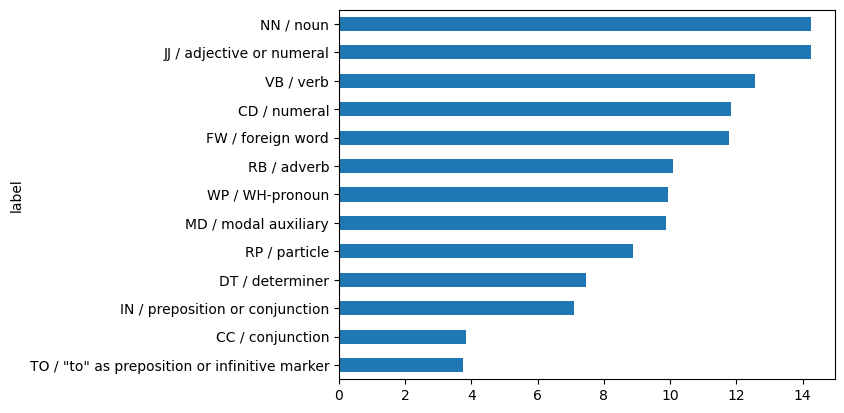

In [117]:
TEST_POS.reset_index().set_index('label').mean_i.sort_values().plot.barh();

## Add features to sentences

In [145]:
TEST_SENTENCES['i_mean'] = TEST.groupby('sent_id').i.mean()
TEST_SENTENCES['pp'] = np.exp2(TEST_SENTENCES.i_mean).round().astype('int')
TEST['code'] = TEST.term_str + '/' + TEST.tag 
TEST_SENTENCES['code'] = TEST.groupby('sent_id').apply(lambda x: ' '.join(x.code))

In [147]:
TEST_SENTENCES.sort_values('pp')

,sent_str,i_mean,pp,code
sent_id,,,,
30,and Mr Woodhouse had not married early,9.286809,625,and/CC mr/NN woodhouse/NN had/VB not/RB marrie...
27,but he was no companion for her,9.477370,713,but/CC he/NN was/VB no/RB companion/NN for/IN ...
20,It was true that her friend was going only hal...,9.552273,751,it/NN was/VB true/JJ that/DT her/VB friend/NN ...
13,She had been a friend and companion such as fe...,9.578352,764,she/NN had/VB been/VB a/DT friend/NN and/CC co...
18,and who had such an affection for her as could...,9.722370,845,and/CC who/WP had/VB such/JJ an/DT affection/N...
33,without activity of mind or body,9.799618,891,without/IN activity/NN of/IN mind/NN or/CC bod...
23,and a Miss Taylor in the house,9.867941,934,and/CC a/DT miss/NN taylor/NN in/IN the/DT hou...
22,only half a mile from them,9.983503,1012,only/RB half/NN a/DT mile/NN from/IN them/RP
4,The want of Miss Taylor would be felt every ho...,10.281959,1245,the/DT want/VB of/IN miss/NN taylor/NN would/M...
